### The German Traffic Sign Benchmark

Student Name 1: Alberto Miño

Student Name 2: Adrian Michelena

In [ ]:
# Download the data base
# !wget -c http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
# !unzip FullIJCNN2013.zip
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# drivePrefix = "/gdrive/My Drive/Colab Notebooks/MUIA-ComputerVision/P4/dataset/"
!unzip -qq -u "/gdrive/My Drive/Colab Notebooks/MUIA-ComputerVision/P4/dataset/FullIJCNN2013.zip"

Mounted at /gdrive


In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'], color="dodgerblue")
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'], color="green")
    axs[0].set_ylim(0, 1)
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1,step=len(model_history.history['accuracy'])/10))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'], color="darkorange")
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'], color="red")
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1,step=len(model_history.history['loss'])/10))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
import numpy as np
import cv2
import pandas as pd

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [ ]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

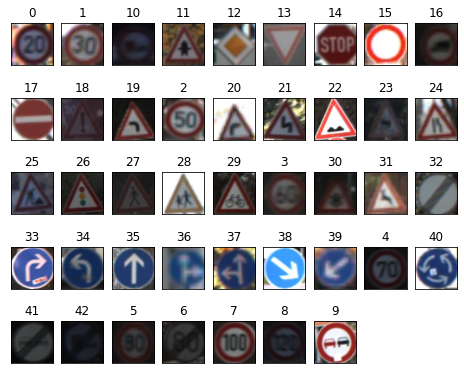

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

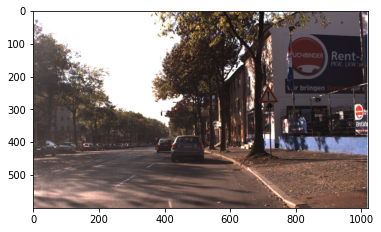

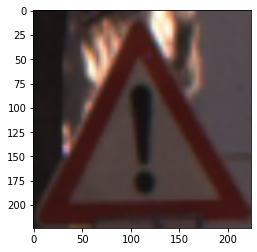

[687.   225.   746.25 280.5 ]
18


In [ ]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
plt.show()
print(train_bboxes[0])
print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

In [ ]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [ ]:
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
                            #  featurewise_center=True,
                            #  featurewise_std_normalization=True,
                             rotation_range=10.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=False,
                            #  zoom_range=0.15,
                             shear_range=0.1,
                             fill_mode='nearest')
datagen.fit(tr_signs)

### Assignment 1: Multi-Layer Perceptron

In [ ]:
# Convolutional Neural Network (CNN)
# Here you are allowed to use convolutional layers
# You may use also any regularizacion (see class slides)

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D
import keras.backend as K
from keras.callbacks import ModelCheckpoint

checkpoint_path = "/gdrive/My Drive/Colab Notebooks/MUIA-ComputerVision/P4/Alberto_TrafficSignRecognitionCNN2/best_epoch_val_acc.ckpt"
checkpoint_callback = ModelCheckpoint(
   checkpoint_path, monitor='val_accuracy', verbose=1, save_weights_only=True,
   # Save weights, every epoch.
   save_freq='epoch',mode='auto',save_best_only=True)

learning_rate=0.001
epochs=1000
batch_size=32
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=int(epochs*0.2) )
p_dropou_layert=[0,0,0.2,0.3,0.5,0.5,0.7]
i=0
d_augm=1

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3),activation='relu', padding='same', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(p_dropou_layert[i]))
i+=1
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(p_dropou_layert[i]))
i+=1
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(p_dropou_layert[i]))
i+=1
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(p_dropou_layert[i]))
i+=1
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(p_dropou_layert[i]))
i+=1
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(p_dropou_layert[i]))
i+=1
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(BatchNormalization())
model.add(Dropout(p_dropou_layert[i]))

model.add(Conv2D(filters=num_classes, kernel_size=(3, 3), padding='valid'))
model.add(Flatten())
model.add(Activation('softmax'))


# opt = optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
opt = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 56, 56, 32)        128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 56, 56, 32)       

In [ ]:
if d_augm==1:
  # Fit the model with real time data augmentation
  print("Fitting model with data augmentation")
  start = time()
  data = model.fit(datagen.flow(tr_signs,tr_labels,batch_size=batch_size), 
                           epochs=epochs, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard, es, checkpoint_callback])
  end = time()
  
else:
  # Fit the model with plain dataset 
  print("Fitting model")
  start = time()
  data = model.fit(tr_signs, tr_labels, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard, es, checkpoint_callback])
  end = time()

Fitting model with data augmentation
Epoch 1/1000
19/19 - 8s - loss: 5.4695 - accuracy: 0.0800 - val_loss: 3.8297 - val_accuracy: 0.0397

Epoch 00001: val_accuracy improved from -inf to 0.03968, saving model to /gdrive/My Drive/Colab Notebooks/MUIA-ComputerVision/P4/Alberto_TrafficSignRecognitionCNN2/best_epoch_val_acc.ckpt
Epoch 2/1000
19/19 - 6s - loss: 4.6520 - accuracy: 0.1517 - val_loss: 4.6501 - val_accuracy: 0.0000e+00

Epoch 00002: val_accuracy did not improve from 0.03968
Epoch 3/1000
19/19 - 7s - loss: 4.2820 - accuracy: 0.2067 - val_loss: 4.6173 - val_accuracy: 0.0238

Epoch 00003: val_accuracy did not improve from 0.03968
Epoch 4/1000
19/19 - 6s - loss: 3.7169 - accuracy: 0.2417 - val_loss: 6.0639 - val_accuracy: 0.0198

Epoch 00004: val_accuracy did not improve from 0.03968
Epoch 5/1000
19/19 - 6s - loss: 3.5540 - accuracy: 0.2717 - val_loss: 5.3848 - val_accuracy: 0.0198

Epoch 00005: val_accuracy did not improve from 0.03968
Epoch 6/1000
19/19 - 6s - loss: 3.1447 - accur

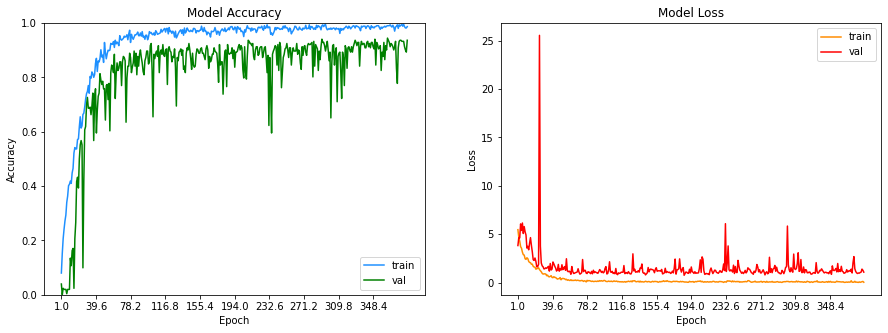

In [ ]:
print("Training CNN took " + str(end - start) + " seconds")
plot_model_history(data)

In [ ]:
start = time()
loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('For final weights configuration:\n\tTest loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

CNN took 0.2529294490814209 seconds
For final weights configuration:
	Test loss: 0.5962536334991455 - Accuracy: 0.9639889001846313


In [ ]:
model.load_weights(checkpoint_path)
start = time()
loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('For best validation accuracy weights configuration found in training:\n\tTest loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

CNN took 0.24784636497497559 seconds
For best validation accuracy weights configuration found in training:
	Test loss: 0.638451337814331 - Accuracy: 0.9667590260505676
